# MNIST Classification Showdown

# 0. Imports and Datasets

In [2]:
# %pip install ml_collections
# %pip install flax
# %pip install bayesian-optimization
# %pip install -qq git+https://github.com/probml/rebayes.git
# %pip install jaxtyping
# %pip install jax-tqdm
# %pip install dynamax

In [2]:
from functools import partial
import time
from typing import Callable, Sequence
import collections.abc
import warnings
import copy
from collections import deque
from tqdm import trange

import ml_collections
import tensorflow_datasets as tfds
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalDiag as MVND
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from flax import linen as nn
from flax.training import train_state
import jax
from jax import jit, vmap, lax, jacfwd
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import jax.random as jr
import optax
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from bayes_opt import BayesianOptimization

jax.numpy.set_printoptions(suppress = True, precision=4)
from rebayes.base import RebayesParams
from rebayes.low_rank_filter.lofi import LoFiParams, RebayesLoFi, LoFiBel
from rebayes.extended_kalman_filter.ekf import RebayesEKF
from rebayes import replay_sgd as rsgd
import demos.showdown.hparam_tune_clf as hp

In [3]:
def get_datasets():
    """Load MNIST train and test datasets into memory."""
    ds_builder = tfds.builder('mnist')
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    train_tvsplit_ds = tfds.as_numpy(ds_builder.as_dataset(split='train[:80%]', batch_size=-1))
    val_tvsplit_ds = tfds.as_numpy(ds_builder.as_dataset(split='train[80%:]', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
    for ds in [train_ds, train_tvsplit_ds, val_tvsplit_ds, test_ds]:
        ds['image'] = jnp.float32(ds['image']) / 255.
    return train_ds, test_ds, train_tvsplit_ds, val_tvsplit_ds

In [4]:
train_ds, test_ds, train_tvsplit_ds, val_tvsplit_ds = get_datasets()

In [5]:
X_train, y_train = jnp.array(train_ds['image']), jnp.array(train_ds['label'])
X_test, y_test = jnp.array(test_ds['image']), jnp.array(test_ds['label'])

In [6]:
# Reshape data
X_train = X_train.reshape(-1, 1, 28, 28, 1)
y_train_ohe = jax.nn.one_hot(y_train, 10)

# 1. Models

In [7]:
class CNN(nn.Module):
    """A simple CNN model."""
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

In [8]:
cnn = CNN()
key = jr.PRNGKey(0)
params = cnn.init(key, jnp.ones([1, 28, 28, 1]))['params']
flat_params, unflatten_fn = ravel_pytree(params)
print(f'Params size = {flat_params.shape}')
state_dim = flat_params.shape[0]

Params size = (421642,)


In [9]:
apply_fn = lambda w, x: cnn.apply({'params': unflatten_fn(w)}, x).ravel()
emission_mean_function=lambda w, x: jax.nn.softmax(apply_fn(w, x))
def emission_cov_function(w, x):
    ps = emission_mean_function(w, x)
    return jnp.diag(ps) - jnp.outer(ps, ps) + 1e-3 * jnp.eye(len(ps)) # Add diagonal to avoid singularity

In [10]:
test_kwargs = {'test': test_ds, 'unflatten_fn': unflatten_fn, 'apply_fn': apply_fn}

In [11]:
def evaluate_neg_log_likelihood(flat_params, unflatten_fn, apply_fn, test_set):
    """ Evaluate negative log likelihood for given parameters and test set
    """
    @jit
    def evaluate_nll(label, image):
        image = image.reshape((1, 28, 28, 1))
        logits = apply_fn(flat_params, image)
        return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=label)
    nlls = vmap(evaluate_nll, (0, 0))(test_set['label'], test_set['image'])
    return nlls.mean()

In [90]:
def evaluate_miscl(flat_params, unflatten_fn, apply_fn, test_set):
    """ Evaluate accuracy for given parameters and test set
    """
    @jit
    def evaluate_miscl(label, image):
        image = image.reshape((1, 28, 28, 1))
        logits = apply_fn(flat_params, image)
        acc_test = (logits.argmax(axis=-1) == label).mean()
        return 1.0 - acc_test
    miscls = vmap(evaluate_miscl, (0, 0))(test_set['label'], test_set['image'])
    return miscls.mean()

In [91]:
def nll_callback(bel, *args, **kwargs):
    test_set = kwargs["test"]
    unflatten_fn, apply_fn = kwargs["unflatten_fn"], kwargs["apply_fn"]
    nll = evaluate_neg_log_likelihood(bel.mean, unflatten_fn, apply_fn, test_set)
    return nll

In [92]:
def miscl_callback(bel, *args, **kwargs):
    test_set = kwargs["test"]
    unflatten_fn, apply_fn = kwargs["unflatten_fn"], kwargs["apply_fn"]
    miscl = evaluate_miscl(bel.mean, unflatten_fn, apply_fn, test_set)
    return miscl

In [13]:
def get_config(
    optimizer='sgd',
    learning_rate=0.01, 
    momentum=2e-1,
    init_var=3e-2,
    num_iter=1,
    batch_size=1, 
    num_epochs=1,
    sample_freq=500,
    posterior_predictive_method='mc',
    seed=0
    ):
    """Get the default hyperparameter configuration."""
    config = ml_collections.ConfigDict()
    config.optimizer = optimizer
    config.learning_rate = learning_rate
    config.momentum = momentum
    config.init_var = init_var
    config.num_iter = num_iter
    config.batch_size = batch_size
    config.num_epochs = num_epochs
    config.sample_freq = sample_freq
    config.posterior_predictive_method = posterior_predictive_method
    config.seed = seed
    return config

# 2. Orth-SVD LoFi

## 2.1 Hyperparam Tuning

In [42]:
def lofi_opt_fn(X, y, log_init_cov, log_dynamics_cov, log_alpha, memory_size, method='orth_svd_lofi'):
    model_params = RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.power(10, log_init_cov),
        dynamics_weights=1.0,
        dynamics_covariance=jnp.power(10, log_dynamics_cov),
        emission_mean_function=emission_mean_function,
        emission_cov_function=emission_cov_function,
        dynamics_covariance_inflation_factor=jnp.power(10, log_alpha)
    )
    lofi_params = LoFiParams(
        memory_size=int(memory_size),
    )
    estimator = RebayesLoFi(model_params, lofi_params, method=method)

    test_kwargs = {'test': test_ds, 'unflatten_fn': unflatten_fn, 'apply_fn': apply_fn}
    bel, output = estimator.scan(X, y, callback=ll_callback, progress_bar=False, **test_kwargs)
    result = output.mean()
    if jnp.isnan(result):
        result = -1e6

    return result

In [43]:
os_lofi_opt_fn = partial(lofi_opt_fn, X=X_train[:1000], y=y_train_ohe[:1000], 
                        memory_size=20, method='orth_svd_lofi')
os_lofi_optimizer = BayesianOptimization(
    f=os_lofi_opt_fn,
    pbounds={
        'log_init_cov': (-6, -0.1),
        'log_dynamics_cov': (-7, -0.1),
        'log_alpha': (-7, -0.1),
    }
)

In [44]:
os_lofi_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------
| 1         | -2.246    | -6.629    | -5.768    | -4.076    |
| 2         | -2.586    | -3.798    | -2.546    | -3.303    |
| 3         | -2.295    | -5.245    | -6.604    | -4.98     |
| 4         | -3.481e+0 | -6.257    | -0.9765   | -1.523    |
| 5         | -34.79    | -2.546    | -1.976    | -0.6006   |
| 6         | -69.51    | -5.766    | -1.446    | -0.3554   |
| 7         | -53.65    | -2.085    | -6.056    | -0.4236   |
| 8         | -23.87    | -3.605    | -0.3811   | -0.6507   |
| 9         | -33.54    | -3.066    | -1.563    | -0.3069   |
| 10        | -33.11    | -3.418    | -0.4907   | -1.073    |
| 11        | -2.197    | -1.934    | -6.911    | -5.124    |
| 12        | -259.2    | -6.543    | -1.301    | -5.583    |
| 13        | -116.1    | -5.499    | -1.057    | -4.763    |
| 14        | -2.154    | -6.571    | -2.877    | -3.685    |
| 15    

In [45]:
# 'log_alpha': -3.934079486335321, 'log_dynamics_cov': -4.7639856457674465, 'log_init_cov': -0.7180969908241464
print(os_lofi_optimizer.max)

{'target': -0.9758458733558655, 'params': {'log_alpha': -3.934079486335321, 'log_dynamics_cov': -4.7639856457674465, 'log_init_cov': -0.7180969908241464}}


## 2.2 Test-Set NLL Evaluation

In [75]:
def evaluate_model(estimator, X, y, test_kwargs, key=0, n_steps=1_000, n_iter=10, callback=nll_callback):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    def _step(_, key):
        indx = jr.choice(key, len(X), (n_steps,))
        X_curr, y_curr = X[indx], y[indx]
        _, nlls = estimator.scan(X_curr, y_curr, callback=callback, **test_kwargs, progress_bar=True)
        return nlls, nlls
    
    keys = jr.split(key, n_iter)
    carry = jnp.zeros((n_steps,))
    _, nlls = lax.scan(_step, carry, keys)
    mean, std = nlls.mean(axis=0), nlls.std(axis=0)

    return mean, std

In [76]:
init_cov = jnp.power(10, -0.7180969908241464)
dynamics_cov = jnp.power(10, -4.7639856457674465)
alpha = jnp.power(10, -3.934079486335321)
method = 'orth_svd_lofi'

model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=init_cov,
    dynamics_weights=1.0,
    dynamics_covariance=dynamics_cov,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    dynamics_covariance_inflation_factor=alpha
)
lofi_params = LoFiParams(
    memory_size=20,
)
os_lofi_estimator = RebayesLoFi(model_params, lofi_params, method=method)

In [47]:
os_lofi_mean, os_lofi_std = evaluate_model(os_lofi_estimator, X_train, y_train_ohe, test_kwargs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [79]:
os_lofi_miscl_mean, os_lofi_miscl_std = evaluate_model(os_lofi_estimator, X_train, y_train_ohe, test_kwargs, callback=miscl_callback)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

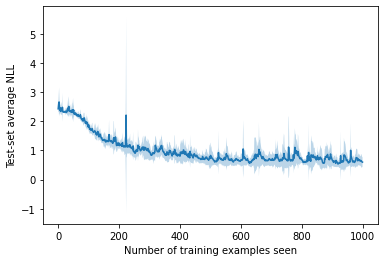

In [48]:
fig, ax = plt.subplots()
ax.plot(os_lofi_mean)
ax.fill_between(
    jnp.arange(os_lofi_mean.shape[0]),
    os_lofi_mean - os_lofi_std,
    os_lofi_mean + os_lofi_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

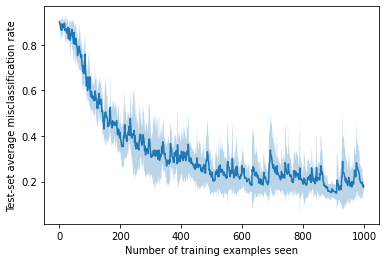

In [80]:
fig, ax = plt.subplots()
ax.plot(os_lofi_miscl_mean)
ax.fill_between(
    jnp.arange(os_lofi_miscl_mean.shape[0]),
    os_lofi_miscl_mean - os_lofi_miscl_std,
    os_lofi_miscl_mean + os_lofi_miscl_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');

# 3. Full-SVD LoFi

## 3.1 Hyperparam Tuning

In [29]:
fs_lofi_opt_fn = partial(lofi_opt_fn, X=X_train[:1000], y=y_train_ohe[:1000], 
                        memory_size=20, method='full_svd_lofi')
fs_lofi_optimizer = BayesianOptimization(
    f=fs_lofi_opt_fn,
    pbounds={
        'log_init_cov': (-6, -0.1),
        'log_dynamics_cov': (-6, -0.1),
        'log_alpha': (-7, -0.1),
    }
)

In [30]:
fs_lofi_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------
| 1         | -2.625    | -6.487    | -3.004    | -5.25     |
| 2         | -1.054    | -5.555    | -4.07     | -4.385    |
| 3         | -23.07    | -5.759    | -3.098    | -2.603    |
| 4         | -336.7    | -4.133    | -0.8859   | -0.4138   |
| 5         | -71.51    | -5.544    | -2.517    | -5.147    |
| 6         | -101.0    | -2.428    | -1.995    | -2.053    |
| 7         | -1e+06    | -0.1494   | -0.2623   | -0.2237   |
| 8         | -82.32    | -2.14     | -1.327    | -4.781    |
| 9         | -3.055    | -4.634    | -1.516    | -5.647    |
| 10        | -58.28    | -2.832    | -1.619    | -1.547    |
| 11        | -1.224e+0 | -2.513    | -1.148    | -0.1331   |
| 12        | -2.035    | -6.165    | -5.399    | -3.376    |
| 13        | -517.9    | -4.311    | -0.2249   | -4.543    |
| 14        | -1.818e+0 | -5.771    | -2.184    | -1.497    |
| 15    

In [31]:
# 'log_alpha': -5.279166870510268, 'log_dynamics_cov': -6.0, 'log_init_cov': -1.2463280105025674
print(fs_lofi_optimizer.max)

{'target': -0.7188226580619812, 'params': {'log_alpha': -5.279166870510268, 'log_dynamics_cov': -6.0, 'log_init_cov': -1.2463280105025674}}


## 3.2 Test-Set NLL Evaluation

In [18]:
init_cov = jnp.power(10, -1.2463280105025674)
dynamics_cov = jnp.power(10, -6.0)
alpha = jnp.power(10, -5.279166870510268)
method = 'full_svd_lofi'

model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=init_cov,
    dynamics_weights=1.0,
    dynamics_covariance=dynamics_cov,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    dynamics_covariance_inflation_factor=alpha
)
lofi_params = LoFiParams(
    memory_size=20,
)
fs_lofi_estimator = RebayesLoFi(model_params, lofi_params, method=method)

In [19]:
fs_lofi_mean, fs_lofi_std = evaluate_model(fs_lofi_estimator, X_train, y_train_ohe, test_kwargs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [82]:
fs_lofi_miscl_mean, fs_lofi_miscl_std = evaluate_model(fs_lofi_estimator, X_train, y_train_ohe, test_kwargs, callback=miscl_callback)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

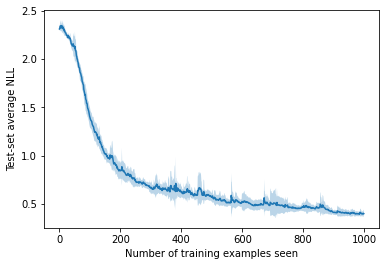

In [81]:
fig, ax = plt.subplots()
ax.plot(fs_lofi_mean)
ax.fill_between(
    jnp.arange(fs_lofi_mean.shape[0]),
    fs_lofi_mean - fs_lofi_std,
    fs_lofi_mean + fs_lofi_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

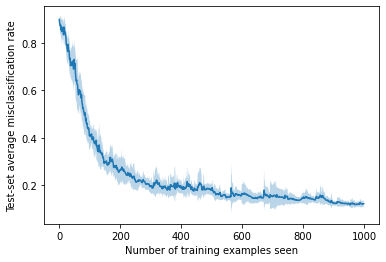

In [83]:
fig, ax = plt.subplots()
ax.plot(fs_lofi_miscl_mean)
ax.fill_between(
    jnp.arange(fs_lofi_miscl_mean.shape[0]),
    fs_lofi_miscl_mean - fs_lofi_miscl_std,
    fs_lofi_miscl_mean + fs_lofi_miscl_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');

# 4. Generalized LoFi

## 4.1 Hyperparam Tuning

In [32]:
g_lofi_opt_fn = partial(lofi_opt_fn, X=X_train[:1000], y=y_train_ohe[:1000], 
                        memory_size=20, method='generalized_lofi')
g_lofi_optimizer = BayesianOptimization(
    f=g_lofi_opt_fn,
    pbounds={
        'log_init_cov': (-6, -0.1),
        'log_dynamics_cov': (-6, -0.1),
        'log_alpha': (-7, -0.1),
    }
)

In [33]:
g_lofi_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------
| 1         | -44.81    | -3.764    | -0.7768   | -4.831    |
| 2         | -1.106    | -6.871    | -4.228    | -4.012    |
| 3         | -141.3    | -4.937    | -0.5967   | -5.692    |
| 4         | -590.6    | -5.176    | -2.223    | -5.774    |
| 5         | -1.625    | -4.989    | -4.99     | -3.31     |
| 6         | -1.749    | -6.379    | -5.144    | -3.163    |
| 7         | -0.6538   | -5.186    | -5.443    | -0.7635   |
| 8         | -1.056    | -2.881    | -3.568    | -5.362    |
| 9         | -63.83    | -4.431    | -2.002    | -5.76     |
| 10        | -1.016    | -5.952    | -3.594    | -4.46     |
| 11        | -88.39    | -1.984    | -1.829    | -2.961    |
| 12        | -2.615e+0 | -2.062    | -2.78     | -5.968    |
| 13        | -1.065    | -5.04     | -3.025    | -1.134    |
| 14        | -0.9939   | -5.773    | -3.558    | -4.112    |
| 15    

In [34]:
# 'log_alpha': -5.18648579941105, 'log_dynamics_cov': -5.442521941808399, 'log_init_cov': -0.7634911622076368
print(g_lofi_optimizer.max)

{'target': -0.65375155210495, 'params': {'log_alpha': -5.18648579941105, 'log_dynamics_cov': -5.442521941808399, 'log_init_cov': -0.7634911622076368}}


## 4.2 Test-Set NLL Evaluation

In [21]:
init_cov = jnp.power(10, -0.7634911622076368)
dynamics_cov = jnp.power(10, -5.442521941808399)
alpha = jnp.power(10, -5.18648579941105)
method = 'generalized_lofi'

model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=init_cov,
    dynamics_weights=1.0,
    dynamics_covariance=dynamics_cov,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    dynamics_covariance_inflation_factor=alpha
)
lofi_params = LoFiParams(
    memory_size=20,
)
g_lofi_estimator = RebayesLoFi(model_params, lofi_params, method=method)

In [22]:
g_lofi_mean, g_lofi_std = evaluate_model(g_lofi_estimator, X_train, y_train_ohe, test_kwargs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [84]:
g_lofi_miscl_mean, g_lofi_miscl_std = evaluate_model(g_lofi_estimator, X_train, y_train_ohe, test_kwargs, callback=miscl_callback)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

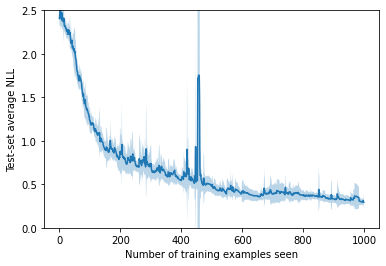

In [24]:
fig, ax = plt.subplots()
ax.plot(g_lofi_mean)
ax.fill_between(
    jnp.arange(g_lofi_mean.shape[0]),
    g_lofi_mean - g_lofi_std,
    g_lofi_mean + g_lofi_std,
    alpha=0.3
)
ax.set_ylim(0.0, 2.5)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

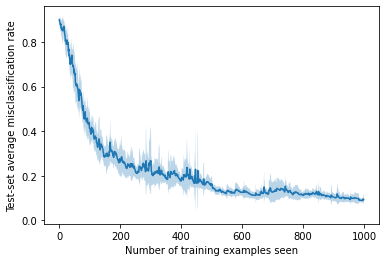

In [85]:
fig, ax = plt.subplots()
ax.plot(g_lofi_miscl_mean)
ax.fill_between(
    jnp.arange(g_lofi_miscl_mean.shape[0]),
    g_lofi_miscl_mean - g_lofi_miscl_std,
    g_lofi_miscl_mean + g_lofi_miscl_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');

# 5. FD-EKF

## 5.1 Hyperparam Tuning

In [35]:
def ekf_opt_fn(X, y, log_init_cov, log_dynamics_cov, log_alpha, method='fdekf'):
    model_params = RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.power(10, log_init_cov),
        dynamics_weights=1.0,
        dynamics_covariance=jnp.power(10, log_dynamics_cov),
        emission_mean_function=emission_mean_function,
        emission_cov_function=emission_cov_function,
        dynamics_covariance_inflation_factor=jnp.power(10, log_alpha)
    )
    estimator = RebayesEKF(model_params, method=method)

    test_kwargs = {'test': test_ds, 'unflatten_fn': unflatten_fn, 'apply_fn': apply_fn}
    bel, output = estimator.scan(X, y, callback=ll_callback, progress_bar=False, **test_kwargs)
    
    result = output.mean()
    if jnp.isnan(result):
        result = -1e6
    return result

In [36]:
fdekf_opt_fn = partial(ekf_opt_fn, X=X_train[:1000], y=y_train_ohe[:1000], method='fdekf')
fdekf_optimizer = BayesianOptimization(
    f=fdekf_opt_fn,
    pbounds={
        'log_init_cov': (-6, -0.1),
        'log_dynamics_cov': (-6, -0.1),
        'log_alpha': (-7, -0.1),
    }
)

In [37]:
fdekf_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------
| 1         | -14.61    | -5.196    | -0.2455   | -5.388    |
| 2         | -1e+06    | -0.4649   | -4.357    | -2.215    |
| 3         | -1e+06    | -0.1484   | -0.6728   | -5.378    |
| 4         | -2.63     | -2.175    | -0.9898   | -0.3878   |
| 5         | -2.09     | -2.119    | -3.977    | -2.775    |
| 6         | -1e+06    | -0.8601   | -3.508    | -4.773    |
| 7         | -19.49    | -1.736    | -1.479    | -4.028    |
| 8         | -1.435    | -3.048    | -3.325    | -4.45     |
| 9         | -1e+06    | -0.833    | -3.329    | -0.5485   |
| 10        | -3.815e+0 | -4.522    | -1.224    | -5.656    |
| 11        | -1e+06    | -0.7346   | -1.412    | -5.229    |
| 12        | -2.346    | -2.016    | -2.884    | -2.472    |
| 13        | -2.486    | -5.431    | -1.368    | -4.441    |
| 14        | -127.8    | -1.437    | -5.59     | -0.1539   |
| 15    

In [38]:
# 'log_alpha': -2.613945101249749, 'log_dynamics_cov': -6.0, 'log_init_cov': -1.7421730226840328
print(fdekf_optimizer.max)

{'target': -1.1577621698379517, 'params': {'log_alpha': -2.613945101249749, 'log_dynamics_cov': -6.0, 'log_init_cov': -1.7421730226840328}}


## 5.2 Test-Set NLL Evaluation

In [25]:
init_cov = jnp.power(10, -1.7421730226840328)
dynamics_cov = jnp.power(10, -6.0)
alpha = jnp.power(10, -2.613945101249749)
method = 'fdekf'

model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=init_cov,
    dynamics_weights=1.0,
    dynamics_covariance=dynamics_cov,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    dynamics_covariance_inflation_factor=alpha
)
fdekf_estimator = RebayesEKF(model_params, method=method)

In [26]:
fdekf_mean, fdekf_std = evaluate_model(fdekf_estimator, X_train, y_train_ohe, test_kwargs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [86]:
fdekf_miscl_mean, fdekf_miscl_std = evaluate_model(fdekf_estimator, X_train, y_train_ohe, test_kwargs, callback=miscl_callback)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

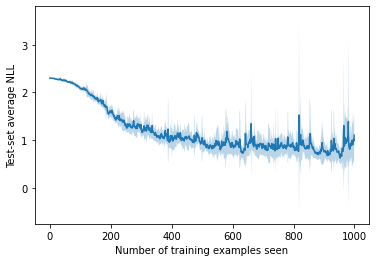

In [27]:
fig, ax = plt.subplots()
ax.plot(fdekf_mean)
ax.fill_between(
    jnp.arange(fdekf_mean.shape[0]),
    fdekf_mean - fdekf_std,
    fdekf_mean + fdekf_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

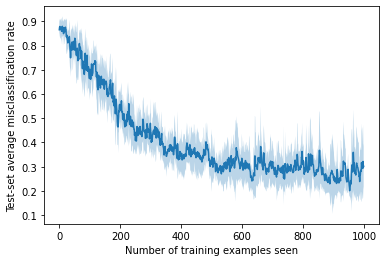

In [87]:
fig, ax = plt.subplots()
ax.plot(fdekf_miscl_mean)
ax.fill_between(
    jnp.arange(fdekf_miscl_mean.shape[0]),
    fdekf_miscl_mean - fdekf_miscl_std,
    fdekf_miscl_mean + fdekf_miscl_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');

# 6. VD-EKF

## 6.1 Hyperparam Tuning

In [39]:
vdekf_opt_fn = partial(ekf_opt_fn, X=X_train[:1000], y=y_train_ohe[:1000], method='vdekf')
vdekf_optimizer = BayesianOptimization(
    f=vdekf_opt_fn,
    pbounds={
        'log_init_cov': (-6, -0.1),
        'log_dynamics_cov': (-6, -0.1),
        'log_alpha': (-7, -0.1),
    }
)

In [40]:
vdekf_optimizer.maximize(
    init_points=20,
    n_iter=25,
)

|   iter    |  target   | log_alpha | log_dy... | log_in... |
-------------------------------------------------------------
| 1         | -2.401    | -6.873    | -2.113    | -5.794    |
| 2         | -1.3      | -6.894    | -4.3      | -2.645    |
| 3         | -2.669    | -1.681    | -1.764    | -3.639    |
| 4         | -2.266    | -6.486    | -5.882    | -5.443    |
| 5         | -1e+06    | -0.6      | -3.118    | -5.869    |
| 6         | -2.414    | -3.855    | -1.831    | -5.861    |
| 7         | -43.15    | -4.661    | -1.818    | -5.473    |
| 8         | -2.971    | -6.342    | -0.5277   | -5.096    |
| 9         | -1.023    | -2.701    | -4.631    | -0.7084   |
| 10        | -1e+06    | -0.7993   | -3.852    | -5.249    |
| 11        | -1e+06    | -0.5547   | -5.84     | -1.934    |
| 12        | -2.328    | -3.635    | -4.421    | -0.135    |
| 13        | -31.88    | -4.609    | -1.849    | -2.279    |
| 14        | -2.415    | -3.023    | -1.947    | -5.311    |
| 15    

In [41]:
# 'log_alpha': -5.666004117070951, 'log_dynamics_cov': -5.095337747557341, 'log_init_cov': -0.46461094604451514
print(vdekf_optimizer.max)

{'target': -0.8458669781684875, 'params': {'log_alpha': -5.666004117070951, 'log_dynamics_cov': -5.095337747557341, 'log_init_cov': -0.46461094604451514}}


## 6.2 Test-Set NLL Evaluation

In [28]:
init_cov = jnp.power(10, -0.464610946044515145)
dynamics_cov = jnp.power(10, -5.095337747557341)
alpha = jnp.power(10, -5.666004117070951)
method = 'vdekf'

model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=init_cov,
    dynamics_weights=1.0,
    dynamics_covariance=dynamics_cov,
    emission_mean_function=emission_mean_function,
    emission_cov_function=emission_cov_function,
    dynamics_covariance_inflation_factor=alpha
)
vdekf_estimator = RebayesEKF(model_params, method=method)

In [29]:
vdekf_mean, vdekf_std = evaluate_model(vdekf_estimator, X_train, y_train_ohe, test_kwargs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [88]:
vdekf_miscl_mean, vdekf_miscl_std = evaluate_model(vdekf_estimator, X_train, y_train_ohe, test_kwargs, callback=miscl_callback)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

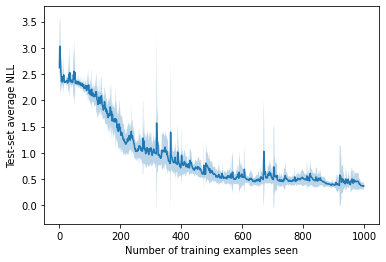

In [30]:
fig, ax = plt.subplots()
ax.plot(vdekf_mean)
ax.fill_between(
    jnp.arange(vdekf_mean.shape[0]),
    vdekf_mean - vdekf_std,
    vdekf_mean + vdekf_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

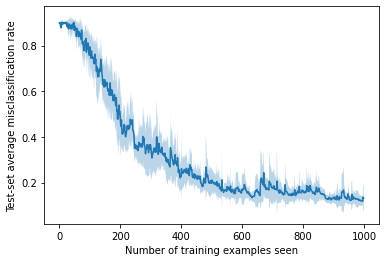

In [89]:
fig, ax = plt.subplots()
ax.plot(vdekf_miscl_mean)
ax.fill_between(
    jnp.arange(vdekf_miscl_mean.shape[0]),
    vdekf_miscl_mean - vdekf_miscl_std,
    vdekf_miscl_mean + vdekf_miscl_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');

# 7. Vanilla SGD

## 7.1 Hyperparam Tuning

In [31]:
@jit
def compute_loss_and_updates_sgd(state, batch_images, batch_labels):
    def loss_fn(params):
        logits = state.apply_fn(params, batch_images)
        loss = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch_labels))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    return grads

In [93]:
def train_and_evaluate_model(state, X_train, y_train, evaluate_fn=evaluate_neg_log_likelihood):
    @jit
    def apply_updates(state, updates):
        return state.apply_gradients(grads=updates)

    def _step(carry, i):
        state = carry
        curr_image = X_train[i].reshape(1,28,28,1)
        curr_label = y_train[i]

        updates = compute_loss_and_updates_sgd(state, curr_image, curr_label)
        state = apply_updates(state, updates)
        nll = evaluate_fn(state.params, unflatten_fn, apply_fn, test_ds)
        
        return state, nll
    
    state, nlls = lax.scan(_step, state, jnp.arange(len(X_train)))
    
    return state, nlls

In [33]:
def sgd_opt_fn(log_lr):
    tx = optax.sgd(jnp.power(10, log_lr))
    opt_state = train_state.TrainState.create(apply_fn=apply_fn, params=flat_params, tx=tx)
    _, nlls = train_and_evaluate_model(opt_state, X_train[:1000], y_train[:1000])

    result = nlls.mean()
    
    if jnp.isnan(result):
        result = 1e6
    return -result

In [34]:
sgd_optimizer = BayesianOptimization(
    f=sgd_opt_fn,
    pbounds={'log_lr': (-6.0, 0.0)}
)

In [35]:
# sgd_optimizer.maximize(
#     init_points=20,
#     n_iter=25,
# )

In [ ]:
# 'log_lr': -1.2630062347890139
print(sgd_optimizer.max)

{'target': -0.9550855159759521, 'params': {'log_lr': -1.2630062347890139}}


## 7.2 Test-Set NLL Evaluation

In [94]:
def evaluate_model_sgd(state, X, y, key=0, n_steps=1_000, n_iter=10, evaluate_fn=evaluate_neg_log_likelihood):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    def _step(_, key):
        indx = jr.choice(key, len(X), (n_steps,))
        X_curr, y_curr = X[indx], y[indx]
        _, nlls = train_and_evaluate_model(state, X_curr, y_curr, evaluate_fn=evaluate_fn)
        return nlls, nlls
    
    keys = jr.split(key, n_iter)
    carry = jnp.zeros((n_steps,))
    _, nlls = lax.scan(_step, carry, keys)
    mean, std = nlls.mean(axis=0), nlls.std(axis=0)

    return mean, std

In [95]:
log_lr = -1.2630062347890139

tx = optax.sgd(jnp.power(10, log_lr))
opt_state = train_state.TrainState.create(apply_fn=apply_fn, params=flat_params, tx=tx)
# _, sgd_nlls = train_and_evaluate_model(opt_state, X_train[:1000], y_train[:1000])

In [38]:
sgd_mean, sgd_std = evaluate_model_sgd(opt_state, X_train, y_train)

In [97]:
sgd_miscl_mean, sgd_miscl_std = evaluate_model_sgd(opt_state, X_train, y_train, evaluate_fn=evaluate_miscl)

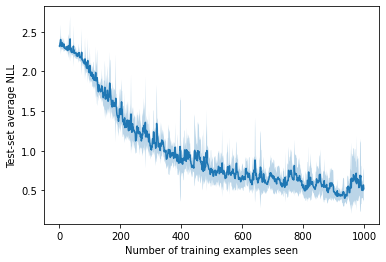

In [39]:
fig, ax = plt.subplots()
ax.plot(sgd_mean)
ax.fill_between(
    jnp.arange(sgd_mean.shape[0]),
    sgd_mean - sgd_std,
    sgd_mean + sgd_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL');

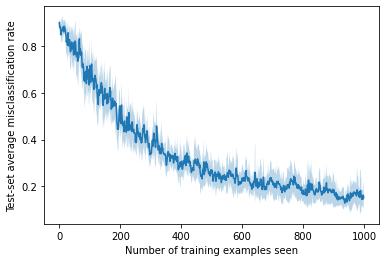

In [98]:
fig, ax = plt.subplots()
ax.plot(sgd_miscl_mean)
ax.fill_between(
    jnp.arange(sgd_miscl_mean.shape[0]),
    sgd_miscl_mean - sgd_miscl_std,
    sgd_miscl_mean + sgd_miscl_std,
    alpha=0.3
)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate');

# 8. Replay-Buffer SGD

## 8.1 Hyperparam Tuning

In [51]:
@partial(jit, static_argnames=("applyfn",))
def lossfn_fifo(params, counter, X, y, applyfn):
    logits = applyfn(params, X)
    probs = jax.nn.softmax(logits)
    
    nll = -y * jnp.log(probs)
    nll = nll.sum(axis=-1)
    loss = (nll * counter).sum() / counter.sum()
    return loss

In [52]:
log_lr = 1e-5
tx = optax.sgd(jnp.power(10, log_lr))

rsgd_state = rsgd.FifoTrainState.create(
    apply_fn=apply_fn,
    params=flat_params,
    tx=tx,
    buffer_size=20,
    dim_features=28 ** 2,
    dim_output=10,
)

rebayes = rsgd.FSGD(lossfn_fifo, n_inner=2)

In [56]:
# _, lls = rebayes.scan(X_train[:1000], y_train_ohe[:1000], bel=rsgd_state, callback=ll_callback, **test_kwargs)

## 8.2 Test-Set NLL Evaluation

# 9. Model Comparison

In [49]:
results = {
    'sgd': (sgd_mean, sgd_std),
    'fdekf': (fdekf_mean, fdekf_std),
    'vdekf': (vdekf_mean, vdekf_std),
    'os_lofi': (os_lofi_mean, os_lofi_std),
    'fs_lofi': (fs_lofi_mean, fs_lofi_std),
    'g_lofi': (g_lofi_mean, g_lofi_std),
}

In [99]:
results_miscl = {
    'sgd': (sgd_miscl_mean, sgd_miscl_std),
    'fdekf': (fdekf_miscl_mean, fdekf_miscl_std),
    'vdekf': (vdekf_miscl_mean, vdekf_miscl_std),
    'os_lofi': (os_lofi_miscl_mean, os_lofi_miscl_std),
    'fs_lofi': (fs_lofi_miscl_mean, fs_lofi_miscl_std),
    'g_lofi': (g_lofi_miscl_mean, g_lofi_miscl_std),
}

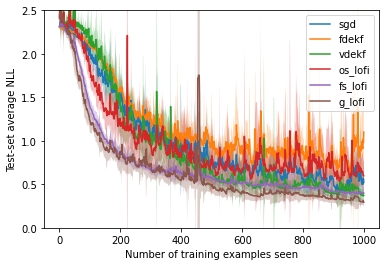

In [50]:
fig, ax = plt.subplots()
for key, val in results.items():
    mean, std = val
    ax.plot(mean, label=key)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std,
        mean + std,
        alpha=0.3
    )
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL')
ax.set_ylim(0.0, 2.5)
ax.legend();

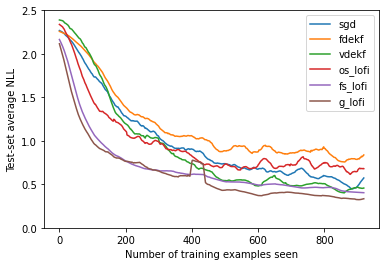

In [102]:
# Smoothed
kernel_size = 40
kernel = jnp.ones((kernel_size,)) / kernel_size

fig, ax = plt.subplots()
for key, val in results.items():
    mean, std = val
    ax.plot(jnp.convolve(mean, kernel, mode='same')[40:-40], label=key)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average NLL')
ax.set_ylim(0.0, 2.5)
ax.legend();

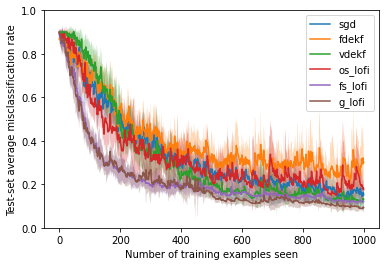

In [101]:
fig, ax = plt.subplots()
for key, val in results_miscl.items():
    mean, std = val
    ax.plot(mean, label=key)
    ax.fill_between(
        jnp.arange(mean.shape[0]),
        mean - std,
        mean + std,
        alpha=0.3
    )
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate')
ax.set_ylim(0.0, 1.0)
ax.legend();

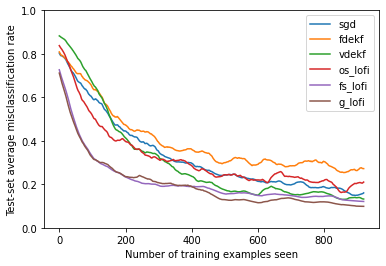

In [103]:
# Smoothed
kernel_size = 40
kernel = jnp.ones((kernel_size,)) / kernel_size

fig, ax = plt.subplots()
for key, val in results_miscl.items():
    mean, std = val
    ax.plot(jnp.convolve(mean, kernel, mode='same')[40:-40], label=key)
ax.set_xlabel('Number of training examples seen')
ax.set_ylabel('Test-set average misclassification rate')
ax.set_ylim(0.0, 1.0)
ax.legend();